# 

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter
from wordcloud import WordCloud

## Carga de datos

In [128]:
df = pd.read_csv('../data/train.csv')

In [129]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Limpieza de datos

Descargamos las _stopwords_ utilizadas para limpiar el texto.

In [130]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [131]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Removing links
    text = re.sub(r'http\S+', '', text)

    # Removing mentions and hashtags
    #   Mentions are removed because they are not important, 
    #   Only removing the '#' from hashtags because the text in the hashtag might be important
    text = re.sub(r'\@\w+|\#', '', text)

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Removing all numbers but 911 because it is an emergency number
    text = re.sub(r'\b(?!911\b)\d+\b', '', text)
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

Aplicamos la función de preprocesamiento al texto.

In [132]:
df['text_clean'] = df['text'].apply(preprocess_text)

In [133]:
df[['text', 'text_clean']].head()

,text,text_clean
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


### Frecuencia de tweets de desastres y no desastres

In [134]:
disaster_tweets = df[df['target'] == 1]
non_disaster_tweets = df[df['target'] == 0]

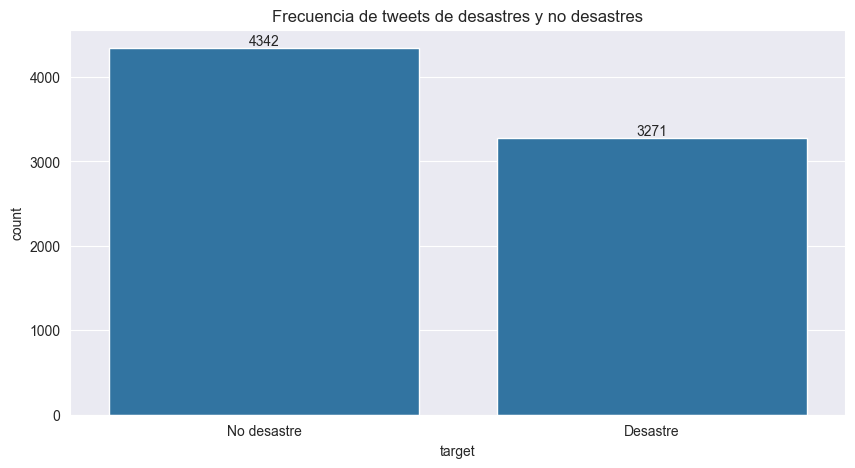

In [135]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='target')
plt.title('Frecuencia de tweets de desastres y no desastres')
plt.xticks([0, 1], ['No desastre', 'Desastre'])
for i, count in enumerate(df['target'].value_counts()):
    plt.text(i, count, count, ha='center', va='bottom')
plt.show()

**¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación?**
Las palabras que podrían ser útiles para hacer un mejor modelo de clasificación son aquellas que se repiten con mayor frecuencia en los tweets de desastres y que no se repiten con tanta frecuencia en los tweets que no son de desastres y viceversa.

**¿Vale la pena explorar bigramas o trigramas para analizar contexto?**
Con base en lo que hemos analizado en la entrega del laboratorio anterior, el desempeño del modelo no mejoró al utilizar bigramas o trigramas (por lo menos, para este dataset. Por lo tanto, no vale la pena explorar bigramas o trigramas para analizar contexto.

### Frecuencia de palabras en tweets de desastres y no desastres

In [136]:
disaster_tweets_words = disaster_tweets['text_clean'].str.split(expand=True).stack()
non_disaster_tweets_words = non_disaster_tweets['text_clean'].str.split(expand=True).stack()

In [137]:
# Count words in disaster tweets and non-disaster tweets
disaster_tweets_word_counts = Counter(disaster_tweets_words)
non_disaster_tweets_word_counts = Counter(non_disaster_tweets_words)

# Find common words and their counts
common_words_counts = disaster_tweets_word_counts & non_disaster_tweets_word_counts

# Convert to a dictionary if needed
common_words_counts_dict = dict(common_words_counts)

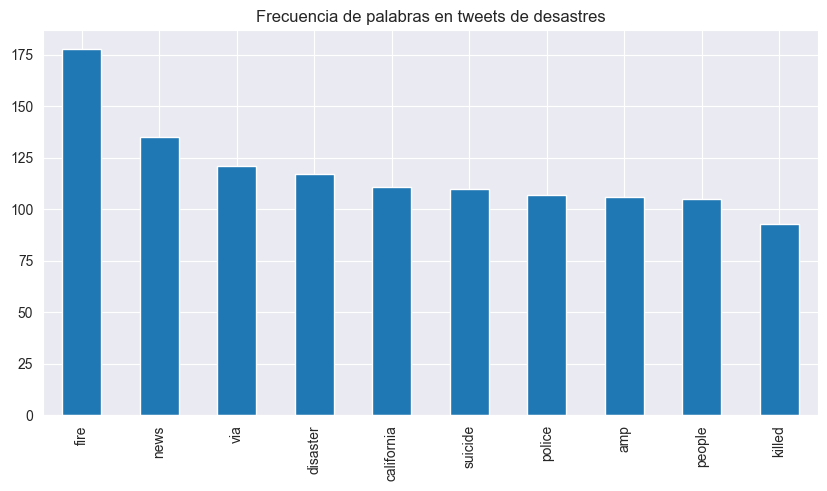

In [138]:
plt.figure(figsize=(10, 5))
disaster_tweets_words.value_counts().head(10).plot(kind='bar')
plt.title('Frecuencia de palabras en tweets de desastres')
plt.show()

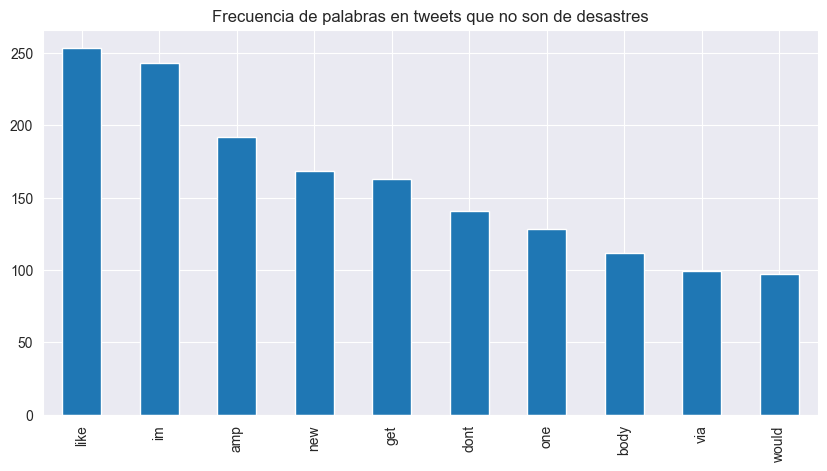

In [139]:
plt.figure(figsize=(10, 5))
non_disaster_tweets_words.value_counts().head(10).plot(kind='bar')
plt.title('Frecuencia de palabras en tweets que no son de desastres')
plt.show()

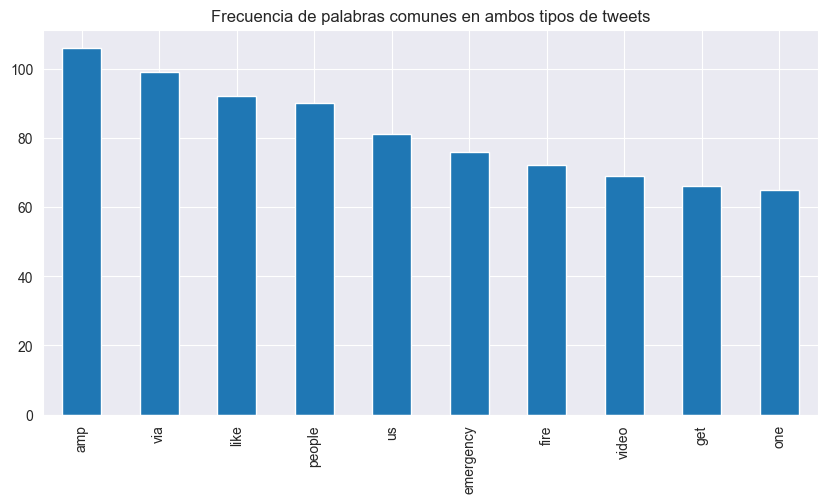

In [140]:
plt.figure(figsize=(10, 5))
pd.Series(common_words_counts_dict).sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Frecuencia de palabras comunes en ambos tipos de tweets')
plt.show()

### Nube de palabras

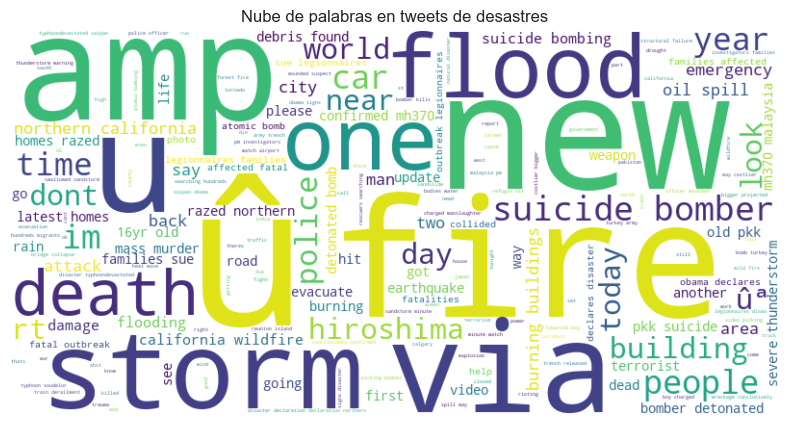

In [141]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_tweets_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras en tweets de desastres')
plt.show()

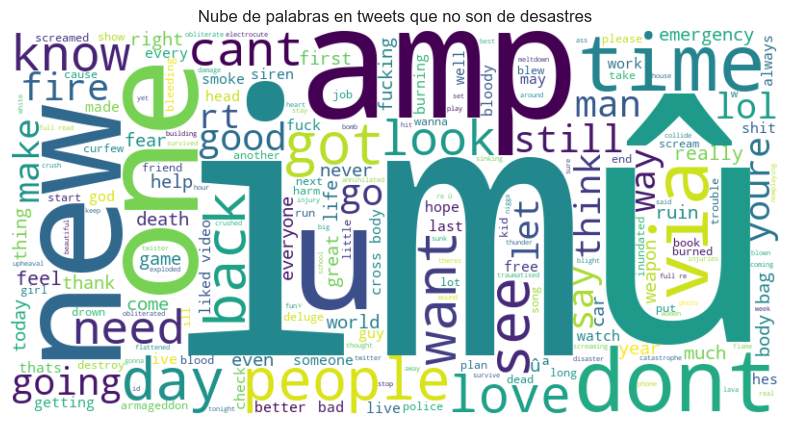

In [142]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_disaster_tweets_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras en tweets que no son de desastres')
plt.show()

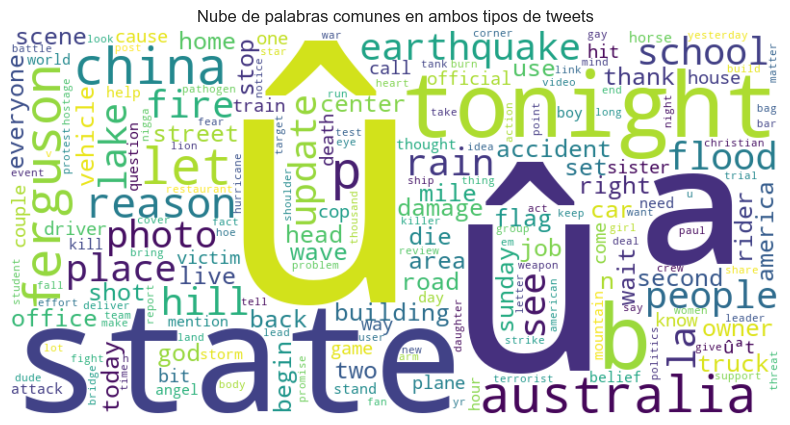

In [143]:
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(common_words_counts_dict))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras comunes en ambos tipos de tweets')
plt.show()

### Discusión sobre las palabras que tienen presencia en todas las categorías
Podemos observar que las palabras que se presentan en ambos tipos de tweet son palabras comunes que no necesariamente aportan información relevante para la clasificación de los tweets. Otras que, parecieran que si son relevantes (cómo fire, earthquake, etc.) tienden a utilizarse en ambos tipos de tweets pero con diferente connotación y son muy dependientes del contexto.

## Clasificación de palabras
Para poder realizar la clasificación de palabras se utilizó el lexicon VADER (Valence Aware Dictionary and sEntiment Reasoner) que es un lexicon y herramienta de análisis de sentimientos que es específico para sentimientos sociales. VADER no solo informa si el sentimiento es positivo o negativo, sino que también informa sobre la intensidad del sentimiento (o, como se refiere en el paper, "valence"). VADER ha sido utilizado en muchos estudios y ha demostrado ser un lexicon muy útil y eficaz para el análisis de sentimientos en redes sociales, en particular. Para más información sobre VADER, se puede consultar el [paper original](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)

Lo relevante para nuestro desarrollo se puede leer en su [README](https://github.com/cjhutto/vaderSentiment/tree/master?tab=readme-ov-file#resources-and-dataset-descriptions) y se hace referencia, particularmente, al archivo [vader_lexicon.txt](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt).

Para poder utilizar la implementación de VADER en Python, se puede utilizar la librería `nltk` que ya tiene implementado el lexicon de VADER.

In [144]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [145]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [146]:
sia = SentimentIntensityAnalyzer()

## Clasificación de Tweets
Se ha creado una variable que indica si un tweet es positivo, negativo o neutro

In [147]:
def classify_tweet(text):
    sentiment = sia.polarity_scores(text)['compound']
    if sentiment > 0.05:
        return 'positive', sentiment
    elif sentiment < -0.05:
        return 'negative', sentiment
    else:
        return 'neutral', sentiment

In [148]:
df['sentiment'], df['sentiment_score'] = zip(*df['text_clean'].apply(classify_tweet))

In [161]:
df[['text_clean', 'sentiment', 'sentiment_score']].head(5)

,text_clean,sentiment,sentiment_score
0,deeds reason earthquake may allah forgive us,positive,0.2732
1,forest fire near la ronge sask canada,negative,-0.3400
2,residents asked shelter place notified officer...,neutral,0.0000
3,people receive wildfires evacuation orders cal...,neutral,0.0000
4,got sent photo ruby alaska smoke wildfires pou...,neutral,0.0000


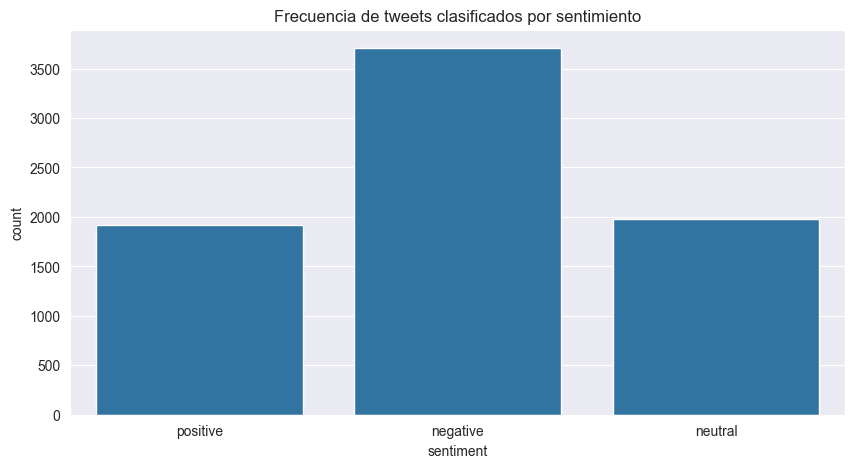

In [150]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='sentiment')
plt.title('Frecuencia de tweets clasificados por sentimiento')
plt.show()

### Tweets más negativos

In [151]:
negative_tweets = df[df['sentiment'] == 'negative']

In [154]:
top_negative_tweets = negative_tweets.sort_values(by='sentiment_score').head(10)

In [160]:
top_negative_tweets[['text_clean', 'sentiment_score', 'target']]

,text_clean,sentiment_score,target
7472,wreck wreck wreck wreck wreck wreck wreck wrec...,-0.9879,0
6411,suicide bomber kills saudi security site mosqu...,-0.9623,1
6393,19th day since 17jul2015 nigeria suicide bomb ...,-0.9595,1
6407,killed sûªarabia mosque suicide bombing suici...,-0.9552,1
472,illegal alien released obamadhs times charged ...,-0.9538,1
1540,bomb crash loot riot emergency pipe bomb nucle...,-0.9524,1
6930,prez mr president biggest terrorist trouble ma...,-0.9493,1
2932,lake sees dead fish poor little guy wonder hap...,-0.9477,0
4561,udhampur terror attack militants attack police...,-0.9451,1
4556,udhampur terror attack militants attack police...,-0.9451,1


### Tweets más positivos

In [156]:
positive_tweets = df[df['sentiment'] == 'positive']

In [157]:
top_positive_tweets = positive_tweets.sort_values(by='sentiment_score', ascending=False).head(10)

In [162]:
top_positive_tweets[['text_clean', 'sentiment_score', 'target']]

,text_clean,sentiment_score,target
6992,check want twister tickets vip experience see ...,0.9682,0
3163,enjoyed show today great fun emergency non eva...,0.9423,0
3382,enjoyed show today great fun emergency non eva...,0.9423,0
6292,todayûªs storm pass let tomorrowûªs light gr...,0.9403,1
7182,nothing wrong lethal weapon series great yes t...,0.9365,0
2238,meditationbymsg ppl got method meditation ampg...,0.9287,0
7449,wounds kissed someone doesnt see disasters sou...,0.9263,0
6295,free ebay sniping rt lumbar extender back stre...,0.9260,0
6560,yeah survived seasons movies lets hope good th...,0.9217,0
1856,love love love remember first crush,0.9186,0


In [164]:
df.loc[6292, 'text']

'Today\x89Ûªs storm will pass; let tomorrow\x89Ûªs light greet you with a kiss. Bask in this loving warmth; let your soul return to bliss.'

### Discusión sobre los tweets más negativos y positivos
Podemos observar que, como lo indica la pregunta, "los tweets de la categoría que indica que habla de un desastre real son más negativos que los de la otra categoría". Se pueden ver algunas excepciones, pero pareciera ser una tendencia que se mantiene. Por ejemplo, en los tweets más positivos, solo hay uno que es considerado un desastre real:

>'Today\x89Ûªs storm will pass; let tomorrow\x89Ûªs light greet you with a kiss. Bask in this loving warmth; let your soul return to bliss.'

Podemos ver que tiene una connotación positiva aunque, en base al contexto, probablemente se refiera a la muerte de alguien.

In [165]:
df.head()

,id,keyword,location,text,target,text_clean,sentiment,sentiment_score
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,positive,0.2732
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,negative,-0.3400
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,neutral,0.0000
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,neutral,0.0000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,neutral,0.0000
